# Coordinate Descent

- 主要讨论Coordinate Descent算法,并用来求解LASSO

## 1. Coordinate Descent

**Alg**: <br/>
$initialization\ x = 0$ <br/>
$repeat\ for\ k = 1,2,...: $
$$
\begin{align}
    x_{1}^{(k)}& \in \operatorname*{\arg\max}_{x_1} f(x_{1}, x_{2}^{(k-1)}, x_{3}^{(k-1)},...,x_{n}^{(k-1)}) \\
    x_{2}^{(k)}& \in \operatorname*{\arg\max}_{x_2} f(x_{1}^{(k)}, x_{2}, x_{3}^{(k-1)},...,x_{n}^{(k-1)}) \\
    &... \\
    x_{n}^{(k)}& \in \operatorname*{\arg\max}_{x_n} f(x_{1}^{(k)}, x_{2}^{(k)}, x_{3}^{(k)},...,x_{n-1}^{(k)},x_{n})
\end{align}
$$

## 2. Lasso regression

$$
\begin{align}
\min_{w} E_{aug}(w)&=\frac{1}{N}\sum_{n=1}^{N}(w^{T}x_{n}-y_{n})^2 + \frac{\lambda}{N}\sum_{q=0}^{Q}|w_q| \\
\frac{\partial E_{aug}(w)}{\partial w_{q}}&=\frac{2}{N}\sum_{n=1}^{N}(w^Tx_{n}-y_{n})x_{n,q} + \frac{\lambda}{N}\partial|w_q| \\
&=\frac{2}{N}\sum_{n=1}^{N}(w_qx_{n,q}^2 + \sum_{p\neq q}w_px_{p,n}x_{q,n}-y_{n}x_{q,n}) + \frac{\lambda}{N}\partial|w_q| \\
&=\frac{2}{N}w_q\sum_{n=1}^{N}x_{n,q}^2 + \frac{2}{N}\sum_{n=1}^{N}(\sum_{p\neq q}w_px_{p,n}x_{q,n}-y_{n}x_{q,n}) + \frac{\lambda}{N}\partial|w_q| \\
&=\frac{2}{N}w_qX_q^{T}X_q + \frac{2}{N}X_q^T(X_{-q}w_{-q}-y) + \frac{\lambda}{N}\partial|w_q| \\
\text{又}\quad &\partial|w_q| =  \begin{cases}
                   1, &w_q > 0 \\
                   [-1,1], &w_q = 0\\
                   -1, &w_q < 0\\
                   \end{cases}\\
\text{从而有}\quad&w_q =       \begin{cases}
                   \frac{X_q^T(y-X_{-q} w_{-q}) - \frac{\lambda}{2}}{X_q^TX_q} & X_q^T(y-X_{-q} w_{-q}) > \frac{\lambda}{2} \\
                   0 & X_q^T(y-X_{-q} w_{-q}) \in [-\frac{\lambda}{2}, \frac{\lambda}{2}] \\
                   \frac{X_q^T(y-X_{-q} w_{-q}) + \frac{\lambda}{2}}{X_q^TX_q} & X_q^T(y-X_{-q} w_{-q}) < -\frac{\lambda}{2}
                   \end{cases}
\end{align}
$$

## 3. 实现

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from sklearn import datasets
from sklearn import linear_model
%matplotlib inline
plt.style.use('seaborn-white')

In [2]:
def lasso_reg(X, y, lambd=0.1, updates=1000, epsilon=1e-6):
    w = np.zeros_like(X[0], dtype=np.float64)
    w_last = w.copy()
    
    Xq_square = [X[:,i].dot(X[:,i]) for i in range(len(w))]
    
    for t in range(0, updates + 1):
        if t % 100 == 0:
            #print('\repisode: ', t, end='')
            pass
            
        for q in range(0, len(w)):
            index = [i for i in range(len(w)) if i!=q]
            
            residual = y - X[:, index].dot(w[index])
            tmp = X[:, q].dot(residual)
            
            if tmp > lambd/2:
                w[q] = (tmp - lambd/2) / Xq_square[q]
            elif tmp < -lambd/2:
                w[q] = (tmp + lambd/2) / Xq_square[q]
            else:
                w[q] = 0.0
        if np.linalg.norm(w_last-w) < epsilon:
            break
        w_last = w.copy()
    return w

In [3]:
X = np.array([[0, 0], [1, 1]])
y = np.array([0,1])
X = np.hstack((np.ones((2,1)), X))
y = y - y.mean()
reg = linear_model.Lasso(alpha=0.1, fit_intercept=False)
reg.fit(X, y)

Lasso(alpha=0.1, copy_X=True, fit_intercept=False, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [4]:
print(reg.coef_)

[-0.09997559  0.39997559  0.        ]


In [5]:
w = lasso_reg(X,y,lambd=2*len(X)*.1)      # 主要是两者对目标函数的定义不同，故调整lambd
print()
print(w)


[-9.99996185e-02  3.99999619e-01  5.55111512e-17]


## 3. Lasso coefficient path

In [6]:
#Load the diabetes dataset. In this case we will not be using a constant intercept feature
diabetes = datasets.load_diabetes()
X = diabetes.data
y = diabetes.target
print(X.shape)
print(y.shape)
print(X[:2])

(442, 10)
(442,)
[[ 0.03807591  0.05068012  0.06169621  0.02187235 -0.0442235  -0.03482076
  -0.04340085 -0.00259226  0.01990842 -0.01764613]
 [-0.00188202 -0.04464164 -0.05147406 -0.02632783 -0.00844872 -0.01916334
   0.07441156 -0.03949338 -0.06832974 -0.09220405]]


In [7]:
alphas = np.logspace(-2,1,100)
coefs_lib = []
coefs_my = []

for alpha in alphas:
    reg = linear_model.Lasso(alpha=alpha, max_iter=1000, tol=1e-6, fit_intercept=False)
    reg.fit(X, y)
    coefs_lib.append(reg.coef_)
    
    coefs_my.append(lasso_reg(X,y,lambd=2*len(X)*alpha))
    
coefs_lib = np.array(coefs_lib)
coefs_my = np.array(coefs_my)

(0.007079457843841388,
 14.12537544622754,
 -354.4395786702171,
 616.6849247928841)

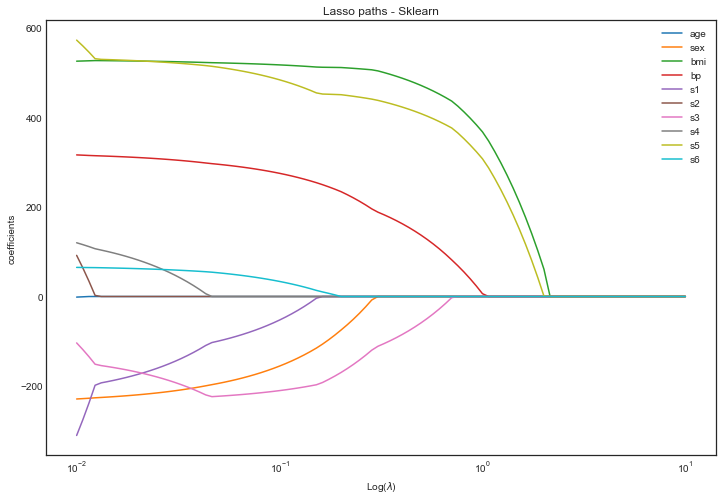

In [8]:
plt.figure(figsize = (12,8))
for i in range(10):
    plt.plot(alphas, coefs_my[:,i], label = diabetes.feature_names[i])

plt.xscale('log')
plt.xlabel('Log($\\lambda$)')
plt.ylabel('coefficients')
plt.title('Lasso paths - Sklearn')
plt.legend()
plt.axis('tight')

(0.007079457843841388, 14.12537544622754, -354.404849586707, 616.6707029880628)

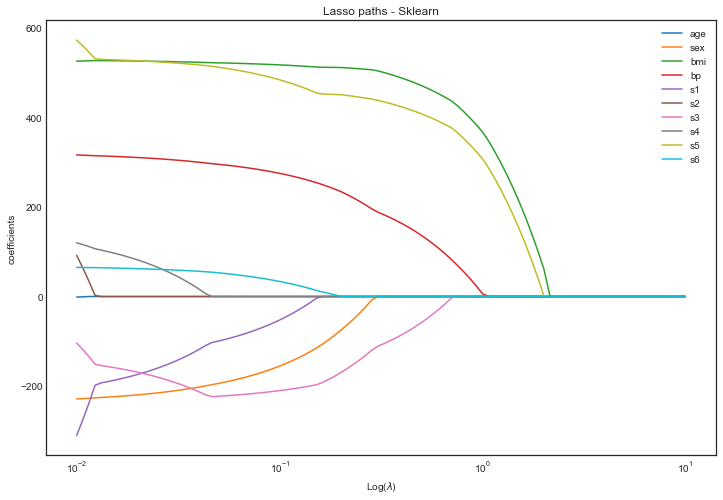

In [9]:
plt.figure(figsize = (12,8))
for i in range(10):
    plt.plot(alphas, coefs_lib[:,i], label = diabetes.feature_names[i])

plt.xscale('log')
plt.xlabel('Log($\\lambda$)')
plt.ylabel('coefficients')
plt.title('Lasso paths - Sklearn')
plt.legend()
plt.axis('tight')

## 4. 参考
- https://www.cs.cmu.edu/~ggordon/10725-F12/slides/25-coord-desc.pdf (coord-desc.pdf)
- 对绝对值函数求导用到了次导数的概念 https://en.wikipedia.org/wiki/Subderivative